# Comparing categories

1) How well do the features of a bicycle determine the label?
2) How well can machine learning detect the type of bicycle?

I do not know yet what exactly I will say / present

## Imports

In [38]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier     #Depth-8 Decision Tree
from sklearn.neighbors import KNeighborsClassifier  #K-Neighbors
from sklearn.ensemble import RandomForestClassifier #Random Forest

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

In [39]:
#more imports
from sklearn.ensemble import AdaBoostClassifier        #AdaBoost
from sklearn.svm import SVC                            #Support Vector Clf.

from sklearn.gaussian_process import GaussianProcessClassifier     #Gaussian Pr. Clf.
from sklearn.neural_network import MLPClassifier                   #3-layer Neural Net, #6-Layer Neural Net
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

In [40]:
#Read Data
data = pd.read_csv("Data/data_processed_cl.csv", index_col=0)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4511 entries, 0 to 4510
Columns: 1847 entries, SSSIDECX3 to SIZE_other
dtypes: float64(1415), int64(429), object(3)
memory usage: 63.6+ MB


There are 3 object columns (non-numeric). Let's check them out:

In [42]:
categorical_cols = data.select_dtypes(include="object").columns
print(len(list(categorical_cols)))
categorical_cols

3


Index(['BIKESTYLE', 'category', 'SIZE_in_text'], dtype='object')

Ah, 
* `BIKESTYLE` and  `category` are my label columns (one at a time) and 
* `SIZE_text` is for ordinal encoding

## Splitting with label = `BIKESTYLE`

In [43]:
y_1 = data.pop("category")
y_2 = data.pop("BIKESTYLE")

In [44]:
X = data 

In [8]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=31416)

## Preprocessor Pipeline

In [9]:
# Select categorical and numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()


In [10]:

# Numerical Pipeline, only with the SimpleImputer(strategy="mean") and MinMaxScaler
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="constant"),   #strategy="constant"
    MinMaxScaler()
)


In [11]:
# Categorical Pipeline

# # # i. Defining the categorical encoder
ordinal_col_names = ['SIZE_text'] 

ordinal_cols = X_cat.columns.get_indexer(ordinal_col_names)
#onehot_cols = X_cat.columns.get_indexer(list(set(X_cat) - set(ordinal_col_names)))


# # # ii. Defining values for Ordinal Encoding
SIZE_text = ["0", "xs", "s", "m", "l", "xl", "xxl", "xxxl"]

ordinal_cats_list = [SIZE_text]

# # # iii. Defining the ColumnTransformer with 2 branches: ordinal & onehot (categorical encoder)
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=ordinal_cats_list), ordinal_cols),
#        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
    ]
)

# # # iv. Categorical pipeline = "NA" imputer + categorical encoder
categoric_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="NA"),
                                 categorical_encoder
                                )


In [12]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

## Preparing the models to be used

In [13]:
def get_model_and_params(model_name, param_grid):
    if model_name == "rforest":
        model = RandomForestClassifier()
        param_grid.update({"randomforestclassifier__warm_start": [True, False],
                "randomforestclassifier__n_estimators": [100, 200],
                "randomforestclassifier__max_depth": range(2, 14),
                "randomforestclassifier__min_samples_leaf": range(2, 10),
                "randomforestclassifier__criterion":["gini", "entropy"]})
    elif model_name == "knn":
        model = KNeighborsClassifier()
        param_grid.update({"kneighborsclassifier__n_neighbors": range(2, 50),
                "kneighborsclassifier__weights": ["uniform", "distance"]})
    elif model_name == "dt":
        model = DecisionTreeClassifier()
        param_grid.update({"decisiontreeclassifier__max_depth": range(2, 14),
                "decisiontreeclassifier__min_samples_leaf": range(2, 12),
#               "decisiontreeclassifier__min_samples_split": range(3, 40, 2),
                "decisiontreeclassifier__criterion":["gini", "entropy"]})
    elif model_name == "Ada":
        model = AdaBoostClassifier()
        param_grid.update({#"adaboostclassifiert__estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
                "adaboostclassifier__n_estimators": [50, 80],
                "adaboostclassifier__learning_rate": [0.5, 1.0, 1.5, 2.0, 2.5]})
    #elif model_name == "SVC": # runtime too long. Stopped after 2 hours 
    #    model = SVC()
    #    param_grid.update({"svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    #            "svc__class_weight": ["balanced", "None"]})
    elif model_name == "GaussPrC":
        model = GaussianProcessClassifier(1.0 * RBF(1.0))
        param_grid.update({"gaussianprocessclassifier__multi_class": ["one_vs_rest", "one_vs_one"]})
    elif model_name == "mlp":
        model = MLPClassifier()
        param_grid.update({"mlpclassifier__hidden_layer_sizes": [(200), (200, 200)],
            "mlpclassifier__max_iter": [3000, 5000]})

    return model, param_grid


## Build evaluation function

In [14]:
def evaluate_model(list_of_models, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": []
    }
    param_grid = {}
    
    for i in list_of_models:
        #reset values to be empty : 
        model = ""
        param_grid.clear()
        param_grid = param_grid_preproc

        # # # # it would nice if I make this into a function get_model_and_params
        model, param_grid = get_model_and_params(i, param_grid)

        #create the full_pipeline
        full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

        # define cross validation
        search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=5,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5
                    )                             

        # fit
        search.fit(X_train, y_train)
        print(search.best_params_)

        score_new["model"].append(i)

        ### testing accuracy
        y_test_pred = search.predict(X_test)
        acc_test = accuracy_score(y_test, y_test_pred)
        score_new["test_acc_score"].append(acc_test)

        #get score of TRAIN-Data (overfitting?)
        y_train_pred = search.predict(X_train)
        acc_train = accuracy_score(y_train, y_train_pred)
        score_new["train_acc_score"].append(acc_train)

        # keep scores of model (optional)
        score_new["best_score_of_CV"].append(search.best_score_)
        score_new["best_params"].append(search.best_params_)

        # confusion matrix
        conf = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                    display_labels=search.classes_)
        disp.plot()
        plt.show()

        #how do I use set_palette()
        #change plt.show() to sns.show()
        #How to set the palette to have the colors of my presentation?

        print(i, model)
        print(pd.DataFrame(conf))
        print("end")
    return pd.DataFrame(score_new)



## Running the pipeline

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'randomforestclassifier__warm_start': False, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'gini'}


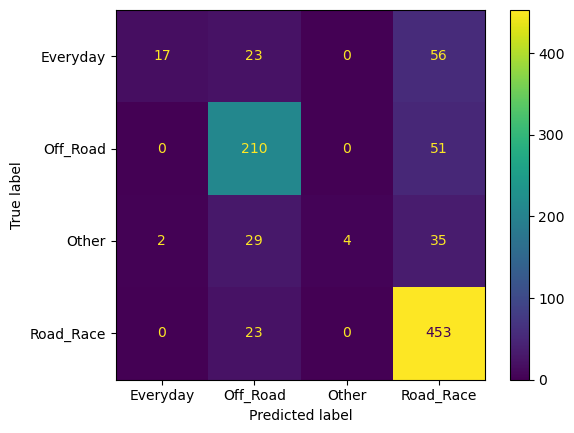

rforest RandomForestClassifier()
    0    1  2    3
0  17   23  0   56
1   0  210  0   51
2   2   29  4   35
3   0   23  0  453
end
Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 12}


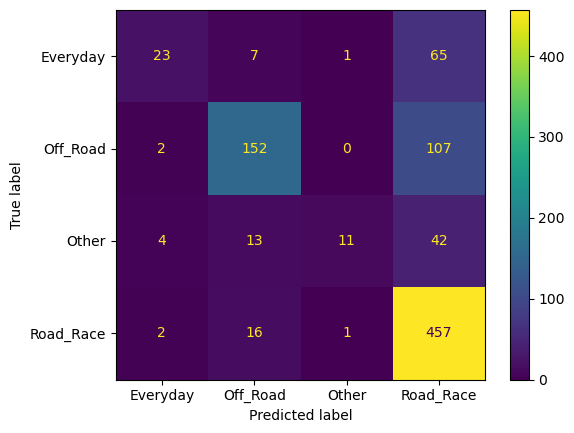

knn KNeighborsClassifier()
    0    1   2    3
0  23    7   1   65
1   2  152   0  107
2   4   13  11   42
3   2   16   1  457
end
Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__criterion': 'gini'}


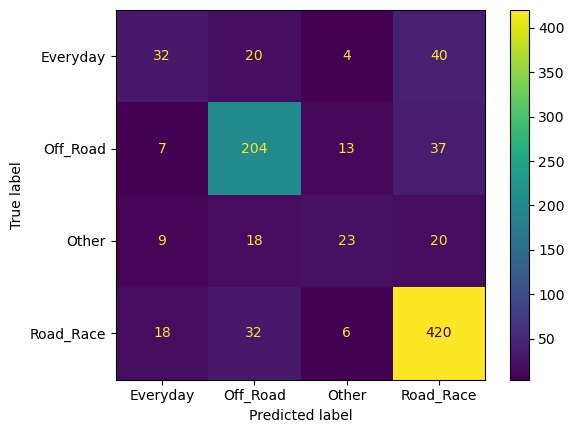

dt DecisionTreeClassifier()
    0    1   2    3
0  32   20   4   40
1   7  204  13   37
2   9   18  23   20
3  18   32   6  420
end


In [15]:
# set models, pass param_grid for preprocessor-pipeline
list_of_models = ["rforest", "knn", "dt"] # , , "knn", "dt", "mlp", "rforest", "knn", "dt", "GaussPrC", "mlp" "SVC" "Ada", , "mlp"

param_grid_preproc = {}

score_new = evaluate_model(list_of_models, param_grid_preproc)

In [16]:
X.shape

(4511, 1845)

In [17]:
(23 +  24 +  2  + 47 +  9 + 195 +  8  + 49 +  7  + 14 + 20 +  29 +  6  + 29  + 4 + 437) 
#903 --> Testset

903

## Keep the scores

In [18]:
#Set to Initialize = True when you want to start over.
initialize_all_scores = True  

if initialize_all_scores == True:
    score_all = {
        "model": [], 
        "test_acc_score" : [],
        "train_acc_score" : [],
        "best_params": [],
        "best_score_of_CV": [],
        "dataset": [],
        "preprocessing": [],
    }
    score_all = pd.DataFrame(score_all)

In [19]:
#description of the current round
#score_all = pd.DataFrame([]) --> only once!
dataset = "processed_cl,18labels" #"reduced,18labels"   #"reduced,19labels"
preprocessing = "numerical_and_ordinalencoding_SIZE_in_text,SimpleImputer,StandardScaler" #"only_numeric_cols,SimpleImputer_Mean"  #"all_columns,SimpleImputer_Mean,OneHot"

score_new["dataset"] = dataset
score_new["preprocessing"] = preprocessing

In [20]:
score_all = pd.concat([score_all, score_new], ignore_index=True)
score_all


#and my model can do it for 19 classes. 
#if I have 2400 points of data 
#and you can still can't tell the difference between the 
#how can a marketing person know the difference

#inbalances in the dataset
#model can be inconsitently classified by the many designers who created bicycles
#steamtube measuring is known to be unreliable

# there might also be some marketing involved

#because poeple need bike companies aren't reinventing the wheel


,model,test_acc_score,train_acc_score,best_params,best_score_of_CV,dataset,preprocessing
0,rforest,0.757475,0.798503,"{'randomforestclassifier__warm_start': False, ...",0.769952,"processed_cl,18labels","numerical_and_ordinalencoding_SIZE_in_text,Sim..."
1,knn,0.712071,1.000000,"{'kneighborsclassifier__weights': 'distance', ...",0.727548,"processed_cl,18labels","numerical_and_ordinalencoding_SIZE_in_text,Sim..."
2,dt,0.751938,0.890798,{'decisiontreeclassifier__min_samples_leaf': 3...,0.765510,"processed_cl,18labels","numerical_and_ordinalencoding_SIZE_in_text,Sim..."


In diesem Fall ist der RandomForest der Beste von den Dreien



## Getting features of decision_tree

### replicate the DT-model

In [21]:
model, param_grid = get_model_and_params(model_name = "dt", param_grid = {})

In [22]:
#create the full_pipeline
full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

# define cross validation
search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=5,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5
                    )                             

# fit
search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='constant')),
                                                                                               ('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               Index(['SSSIDECX3', 'SSSIDECX2', 'SSSIDECX1', 'SSSIDECY2', 'SSSIDECY1',
       'STEMBENDS', 'FRONTROTORBOLTS', 'Shoe up angle',
       'Down tube front diamete...
                                                                               Index(['SIZE_in_text'],

In [23]:
### testing accuracy
y_test_pred = search.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
acc_test


0.751937984496124

In [24]:

#get score of TRAIN-Data (overfitting?)
y_train_pred = search.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
acc_train


0.8957871396895787

### Get features out for a random forest

In [25]:
feature_names = X.columns

### Get features out for a decision tree

In [26]:
# save feature names for later use
import numpy as np

feature_names = np.array(X.columns)


In [27]:
len(feature_names) # length 1

1845

In [28]:
feature_names = feature_names.reshape(-1, 1)  # now it's stored. but there were two [[]]. 
# Let's see if they disturb

In [29]:
feature_names = feature_names.flatten()

In [30]:
# access the DT model in the pipe
# which position?
full_pipe.steps[2]

('decisiontreeclassifier', DecisionTreeClassifier())

In [31]:
# access the model via
decision_tree_model = search.best_estimator_.named_steps["decisiontreeclassifier"]
importances = decision_tree_model.feature_importances_
importances

array([0.00198384, 0.00213992, 0.        , ..., 0.00662954, 0.        ,
       0.        ])

In [32]:
type(importances)

numpy.ndarray

In [33]:
len(importances)

1845

In [34]:
len(feature_names)

1845

In [35]:
features_df = {
    "columns": feature_names,
    "importance": importances}

features_df = pd.DataFrame(features_df)

In [36]:
features_df.tail(10)

# the model was so good because there were two columns still in there: "PERCENT", "COUNT"

,columns,importance
1835,CSAUX3_MM_RATIO OHCLASS: 0,0.00000
1836,CSAUX3_MM_RATIO OHCLASS: 1,0.00000
1837,bottle SEATTUBE0 show OHCLASS: False,0.00000
1838,bottle SEATTUBE0 show OHCLASS: True,0.00000
1839,bottle DOWNTUBE0 show OHCLASS: False,0.00000
1840,bottle DOWNTUBE0 show OHCLASS: True,0.00000
1841,SIZE_in_cm,0.00000
1842,SIZE_in_inch,0.00663
1843,SIZE_in_text,0.00000
1844,SIZE_other,0.00000


In [37]:
### for forests
#import numpy as np
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

#forest_importances = pd.Series(importances, index=feature_names)

#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()